<a href="https://colab.research.google.com/github/sankethk1/Time-series-forecasing-using-XGBoost/blob/main/Xgboost_time_series_forecasting_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import math
import matplotlib
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline




In [ ]:
pred_day = 1990
H = 21
train_size = 1008
val_size = 350
N = 10
n_estimators = 160
max_depth = 3
learning_rate = 0.01
min_child_weight = 5
train_val_size = train_size + val_size

In [ ]:
def get_mape(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def get_rmse(a, b):

    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [ ]:
def mov_avg(df, col, N):

    mean_list = df[col].rolling(window = N, min_periods=1).mean()
    std_list = df[col].rolling(window = N, min_periods=1).std()

    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    df_new = df.copy()
    df_new[col + '_mean'] = mean_list
    df_new[col + '_std'] = std_list

    return df_new

def do_scaling(df, N):

    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    for n in range(N,0,-1):
        df.loc[:, 'adj_close_scaled_lag_'+str(n)] = \
            (df['adj_close_lag_'+str(n)] - df['adj_close_mean']) / df['adj_close_std']

        df.drop(['adj_close_lag_'+str(n)], axis=1, inplace=True)

    return df

def add_lags(df, N, lag_cols):

    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))]
    merging_keys = ['order_day']
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()


        train_shift['order_day'] = train_shift['order_day'] + shift

        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left')
    del train_shift

    return df_w_lags

def pred_xgboost(model, N, H, prev_vals, prev_mean_val, prev_std_val):

    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val

        # Create the features dataframe
        X = defaultdict(list)
        for n in range(N,0,-1):
            X['adj_close_scaled_lag_'+str(n)] = [forecast_scaled[-n]]
        X = pd.DataFrame(X)

        # Do prediction
        est_scaled = model.predict(X)

        # Unscale the prediction
        forecast = np.concatenate([forecast,
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])

        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])

    return forecast[-H:]

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.

    '''

    model = XGBRegressor(objective ='reg:squarederror',

                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight
                         )


    model.fit(X_train_scaled, y_train_scaled)
    est = pred_xgboost(model, N, H, prev_vals, prev_mean_val, prev_std_val)
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)


    return rmse, mape, est, model.feature_importances_

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1):

    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    preds_dict = {}


    df = add_lags(df, N, ['adj_close'])
    df = mov_avg(df, 'adj_close', N)
    df = do_scaling(df, N)


    features = []
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))

    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()


        train.dropna(axis=0, how='any', inplace=True)

        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        y_test = test['adj_close']
        prev_vals = train[-N:]['adj_close'].to_numpy()
        prev_mean_val = test.iloc[0]['adj_close_mean']
        prev_std_val = test.iloc[0]['adj_close_std']

        rmse, mape, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,

                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight
                                                        )


        rmse_list.append(rmse)
        mape_list.append(mape)
        preds_dict[i] = est

    return np.mean(rmse_list), np.mean(mape_list), preds_dict

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1
                              ):

    df = add_lags(df, N, ['adj_close'])
    df = mov_avg(df, 'adj_close', N)
    df = do_scaling(df, N)


    features = []
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))


    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()


    train.dropna(axis=0, how='any', inplace=True)

    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    y_test = test['adj_close']
    prev_vals = train[-N:]['adj_close'].to_numpy()
    prev_mean_val = test.iloc[0]['adj_close_mean']
    prev_std_val = test.iloc[0]['adj_close_std']

    rmse, mape, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                     )

    return rmse, mape, est, feature_importances, features

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving titan.csv to titan.csv


In [ ]:
df = pd.read_csv('titan.csv')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.head()

,date,adj_close,year,week,day_of_week,month,day,is_month_start,is_month_end,is_year_start,is_year_end,is_quarter_start,is_quarter_end
0,01-01-2014,218.49,2014,1,3,1,1,True,False,True,False,True,False
1,02-01-2014,214.28,2014,1,4,1,2,False,False,False,False,False,False
2,03-01-2014,215.27,2014,1,5,1,3,False,False,False,False,False,False
3,06-01-2014,215.65,2014,2,1,1,6,False,False,False,False,False,False
4,07-01-2014,213.99,2014,2,2,1,7,False,False,False,False,False,False


In [ ]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1990, date 28-01-2022, with forecast horizon H = 21


In [ ]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (1008, 13)
val.shape = (350, 13)
train_val.shape = (1358, 13)
test.shape = (21, 13)


In [ ]:
rmse_bef_tuning, mape_bef_tuning,  preds_dict = \
                                                      get_error_metrics(train_val, train_size, N,    H, n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,min_child_weight=min_child_weight  )
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)


RMSE = 91.419
MAPE = 4.384%


In [ ]:
test_rmse_bef_tuning, test_mape_bef_tuning,  est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],  train_size+val_size,  N, H,  n_estimators=n_estimators,max_depth=max_depth,  learning_rate=0.01,  min_child_weight=5 )

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)


RMSE = 33.935
MAPE = 1.164%


In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=test['date'], y=test['adj_close'], mode='lines', name='test',  line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], y=est, mode='lines', name='predictions', line=dict(color='red')))
fig.update_layout(yaxis=dict(title='INR'), xaxis=dict(title='date'))

In [ ]:

param_label = 'n_estimators'
param_list = range(1, 200, 20)

param2_label = 'max_depth'
param2_list = [3]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean,  _ = get_error_metrics(train_val, train_size, N, H,  n_estimators=param,  max_depth=param2,  learning_rate=learning_rate, min_child_weight=min_child_weight  )

        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)


error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-34-5937e7f0abd4>:11: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 1.22


,n_estimators,max_depth,rmse,mape
0,1,3,94.129747,4.577788
1,21,3,93.623072,4.542685
2,41,3,93.373989,4.524728
3,61,3,92.831590,4.489784
4,81,3,92.435243,4.461143
5,101,3,92.495127,4.462600
6,121,3,92.210369,4.432015
7,141,3,91.647621,4.398402
8,161,3,91.451859,4.386758
9,181,3,91.907201,4.419741


In [ ]:

temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]


for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color='b', marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left')

In [ ]:
param_label = 'learning_rate'
param_list = [0.01]

param2_label = 'min_child_weight'
param2_list = range(4, 9 ,1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean,  _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N,
                                                              H,

                                                              n_estimators=161,
                                                              max_depth=3,
                                                              learning_rate=param,
                                                              min_child_weight=param2
                                                              )

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)


error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate

<ipython-input-49-906f26f28902>:10: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/1 [00:00<?, ?it/s]

Minutes taken = 1.14


,learning_rate,min_child_weight,rmse,mape
0,0.01,4,91.318483,4.382258
1,0.01,5,91.451859,4.386758
2,0.01,6,91.300462,4.379592
3,0.01,7,91.092108,4.366156
4,0.01,8,91.240811,4.376431


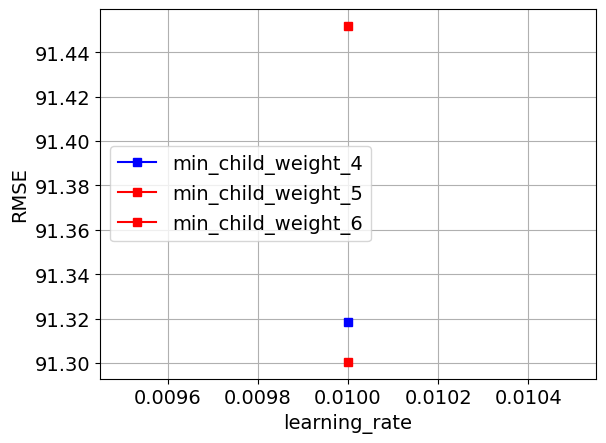

In [ ]:

figure = error_rate[error_rate[param2_label]==param2_list[0]]
ax = figure.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color= 'r', marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

plt.legend(legend_list, loc='center left') # positions legend outside figure

In [ ]:
rmse_aft_tuning, mape_aft_tuning,  preds_dict = \
                                                      get_error_metrics(train_val, train_size, N,  H,  n_estimators=161, max_depth=3,  learning_rate=0.01, min_child_weight=7)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)


RMSE = 91.092
MAPE = 4.366%


In [ ]:
test_rmse_aft_tuning, test_mape_aft_tuning,est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       n_estimators=161,
                                                                       max_depth=3,
                                                                       learning_rate=0.01,
                                                                       min_child_weight=7
                                                                       )


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)


RMSE = 36.195
MAPE = 1.272%


In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(x=test['date'],
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'],
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(yaxis=dict(title='INR'),
                  xaxis=dict(title='date'))